# TF Binding Network Construction with scMagnify 

## Preliminaries

In this tutorial, you will learn how to:

- **Metacell/Pseudobulk Construction.** Use `SEACells` {cite}`Persad_2023` to construct metacells from single-cell multiome data.
- **cCREs Identification** Identify significant peak–gene associations to get cCREs. 
- **Motif Scan.** Following the identification of cCREs, scMagnify scans the DNA sequences of candiate regions to identify transcription factor (TF)-binding motifs. 

:::{note}

This tutorial aims to assist users in preprocessing the scATACseq data for scMagnify analysis. For detailed instructions on the usage of [SEACells](https://github.com/dpeerlab/SEACells), please refer to the official tutorial.

:::

## Import packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
from numba.core.errors import NumbaDeprecationWarning
warnings.simplefilter("ignore", category=NumbaDeprecationWarning)
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

In [3]:
import os
import sys
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import scanpy as sc

In [5]:
import scmagnify as scm
import scmagnify.logging as logg
from scmagnify.settings import settings


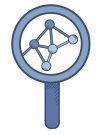

In [6]:
scm.info()

## Configurations

In [7]:
scm.settings.verbosity = 2

As in the previous tutorial, we first ensure the necessary built-in data is available. `scMagnify` will check the cache location; if the data is already present, it will not be downloaded again.

In [8]:
scm.datasets.fetch_scm_data()

INFO     Data already processed and available at: /mnt/TrueNas/project/chenxufeng/Caches/scmagnify/scm_data

'/mnt/TrueNas/project/chenxufeng/Caches/scmagnify/scm_data'

In [9]:
%matplotlib inline

scm.settings.set_figure_params(
    dpi=100,
    facecolor="white",
    frameon=False,
) 
# Load fonts from scm_data
scm.load_fonts(["Arial"])

plt.rcParams["font.family"] = "Arial"
plt.rcParams['grid.alpha'] = 0

In [10]:
# Setting a workspace
dirPjtHome = "/mnt/TrueNas/project/chenxufeng/Data/PMID36973557_NatBiotechnol2023_T-cell-depleted/"
workDir = os.path.join(dirPjtHome, "scmagnify_wd")
scm.set_workspace(workDir)

workspace: /mnt/TrueNas/project/chenxufeng/Data/PMID36973557_NatBiotechnol2023_T-cell-depleted/scmagnify_wd/
├── data
├── models
├── tmpfiles
└── figures

In [11]:
# Set up Reference Genome
scm.set_genome(
    version="hg38",
    genomes_dir="/home/chenxufeng/picb_cxf/Ref/human/hg38/"
)

                        Genome Information                        
┏━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Version ┃ Provider ┃ Directory                                 ┃
┡━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ hg38    │ UCSC     │ /home/chenxufeng/picb_cxf/Ref/human/hg38/ │
└─────────┴──────────┴───────────────────────────────────────────┘

## Load the data

In [9]:
mdata = scm.read(os.path.join(settings.data_dir, "mdata_tcelldep-bm_01.h5mu"))

In [10]:
mdata

MuData object with n_obs × n_vars = 8627 × 233703
  2 modalities
    ATAC:	8627 x 216477
      obs:	'Sample', 'TSSEnrichment', 'ReadsInTSS', 'ReadsInPromoter', 'ReadsInBlacklist', 'PromoterRatio', 'PassQC', 'NucleosomeRatio', 'nMultiFrags', 'nMonoFrags', 'nFrags', 'nDiFrags', 'BlacklistRatio', 'Clusters', 'ReadsInPeaks', 'FRIP', 'leiden', 'phenograph', 'celltype', 'SEACell', 'sample'
      var:	'seqnames', 'start', 'end', 'width', 'strand', 'score', 'replicateScoreQuantile', 'groupScoreQuantile', 'Reproducibility', 'GroupReplicate', 'nearestGene', 'distToGeneStart', 'peakType', 'distToTSS', 'nearestTSS', 'GC', 'idx', 'N', 'Bcells_primed', 'Bcells_lineage_specific'
      uns:	'FIMOColumns', 'GeneScoresColumns', 'InSilicoChipColumns', 'celltype_colors', 'celltype_combined_colors', 'leiden', 'leiden_colors', 'neighbors', 'phenograph_colors', 'tab20', 'umap'
      obsm:	'DM_EigenVectors', 'GeneScores', 'X_svd', 'X_umap'
      varm:	'FIMO', 'InSilicoChip', 'InSilicoChip_Corrs', 'OpenPeaks'
      layers:	'counts', 'tf_idf'
      obsp:	'ImputeWeights', 'connectivities', 'distances'
    RNA:	8627 x 17226
      obs:	'sample', 'celltype', 'palantir_pseudotime', 'macrostates_fwd', 'clusters_gradients', 'term_states_fwd', 'term_states_fwd_probs', 'init_states_fwd', 'init_states_fwd_probs'
      var:	'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'T_fwd_params', 'celltype_colors', 'clusters_gradients_colors', 'coarse_fwd', 'custom_branch_mask_columns', 'dea_celltype', 'dendrogram_celltype', 'eigendecomposition_fwd', 'hvg', 'init_states_fwd_colors', 'lineage_colors', 'log1p', 'macrostates_fwd_colors', 'neighbors', 'pca', 'sample_colors', 'schur_matrix_fwd', 'term_states_fwd_colors', 'umap'
      obsm:	'T_fwd_umap', 'X_FDL', 'X_fate_simplex_fwd', 'X_pca', 'X_umap', 'branch_masks', 'cell_state_masks', 'cellrank_branch_masks', 'cellrank_fate_probabilities', 'cellrank_masks', 'init_states_fwd_memberships', 'lineages_fwd', 'macrostates_fwd_memberships', 'palantir_branch_probs', 'palantir_fate_probabilities', 'palantir_lineage_cells', 'schur_vectors_fwd'
      varm:	'PCs', 'geneXTF'
      layers:	'MAGIC_imputed_data', 'counts'
      obsp:	'connectivities', 'distances', 'knn'

## Metacell/Pseudobulk construction


`scMagnify` utilizes `SEACells` {cite}`Persad_2023` to construct metacells, which represent robust cellular states by aggregating data from groups of similar single cells.

We use the `scm.tl.build_metacells_SEACells` wrapper function for this process. **This function builds the metacells based on a specified dimensionality reduction (DR) result**—in this case, the `X_pca` from the RNA modality (as set by `rna_dr_key`).

Once the metacells are defined, the function aggregates the raw `counts` from both the RNA and ATAC layers (`rna_layer`, `atac_layer`). It also summarizes other important metadata from `adata.obs`, such as `celltype` (defined by `groupby`) and `palantir_pseudotime` (defined by `t_key`), into the new `meta_mdata` object.



INFO     Using layer: counts

Welcome to SEACells!
Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...
Making graph symmetric...
Parameter graph_construction = union being used to build KNN graph...
Computing RBF kernel...
Building similarity LIL matrix...
Constructing CSR matrix...
Building kernel on X_pca
Computing diffusion components from X_pca for waypoint initialization ... 
Determing nearest neighbor graph...
Done.
Sampling waypoints ...
Done.
Selecting 100 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...
Selecting 15 cells from greedy initialization.
Randomly initialized A matrix.
Setting convergence threshold at 0.00173
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Converged after 24 iterations.
Welcome to SEACells!
Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...
Maki

INFO     Running SEACells model for RNA data...

Welcome to SEACells!
Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/8627 [00:00<?, ?it/s]

Making graph symmetric...
Parameter graph_construction = union being used to build KNN graph...
Computing RBF kernel...


  0%|          | 0/8627 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/8627 [00:00<?, ?it/s]

Constructing CSR matrix...
Building kernel on X_pca
Computing diffusion components from X_pca for waypoint initialization ... 
Determing nearest neighbor graph...
Done.
Sampling waypoints ...
Done.
Selecting 100 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:00<00:00, 238.85it/s]


Selecting 15 cells from greedy initialization.
Randomly initialized A matrix.
Setting convergence threshold at 0.00173
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Converged after 24 iterations.


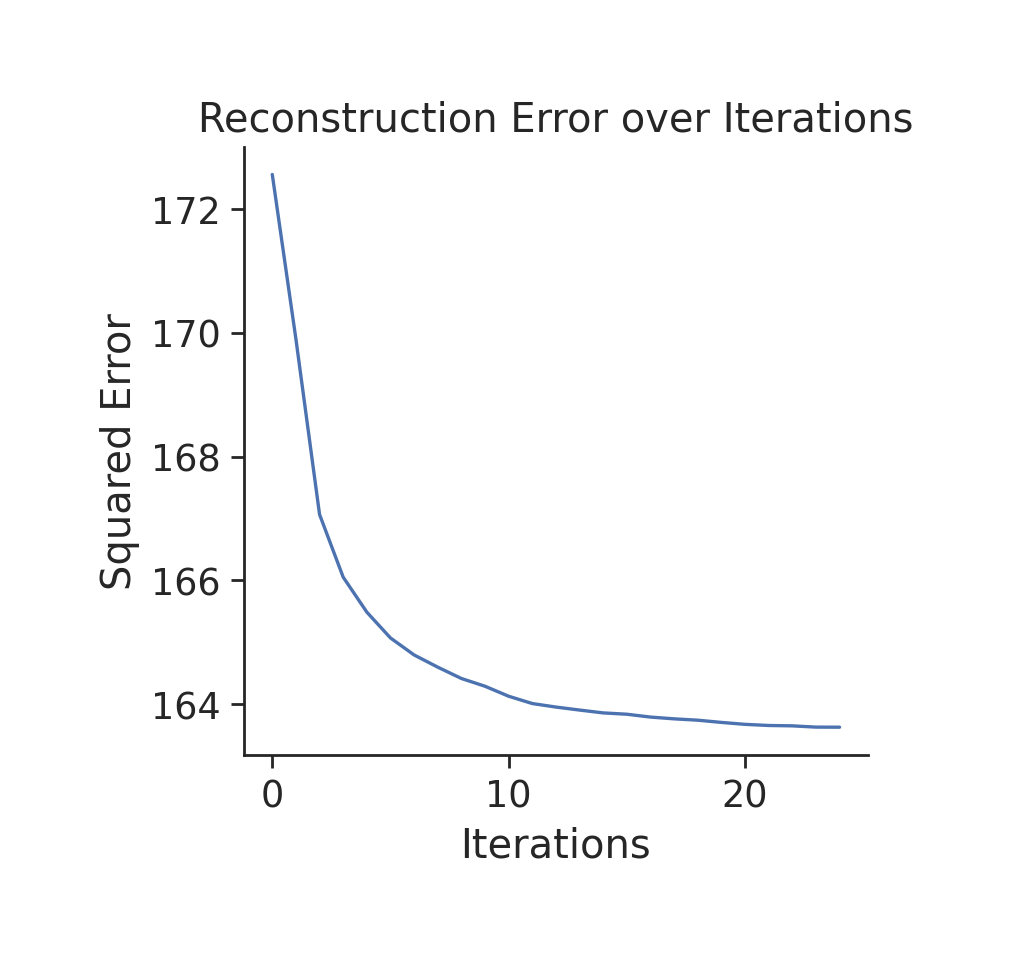

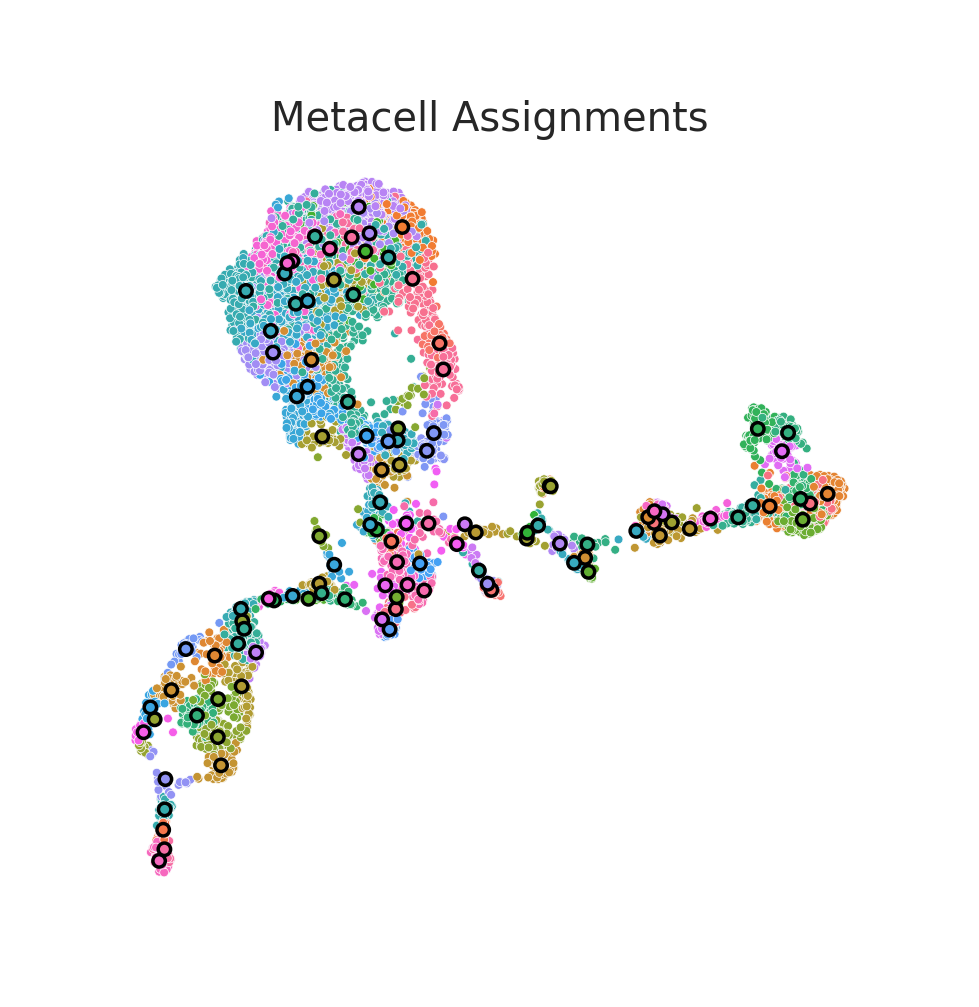

INFO     Running SEACells model for ATAC data...

Welcome to SEACells!
Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/8627 [00:00<?, ?it/s]

Making graph symmetric...
Parameter graph_construction = union being used to build KNN graph...
Computing RBF kernel...


  0%|          | 0/8627 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/8627 [00:00<?, ?it/s]

Constructing CSR matrix...
Building kernel on X_svd
Computing diffusion components from X_svd for waypoint initialization ... 
Determing nearest neighbor graph...
Done.
Sampling waypoints ...
Done.
Selecting 104 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 160.18it/s]


Selecting 11 cells from greedy initialization.
Randomly initialized A matrix.
Setting convergence threshold at 0.00166
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Starting iteration 30.
Completed iteration 30.
Converged after 33 iterations.


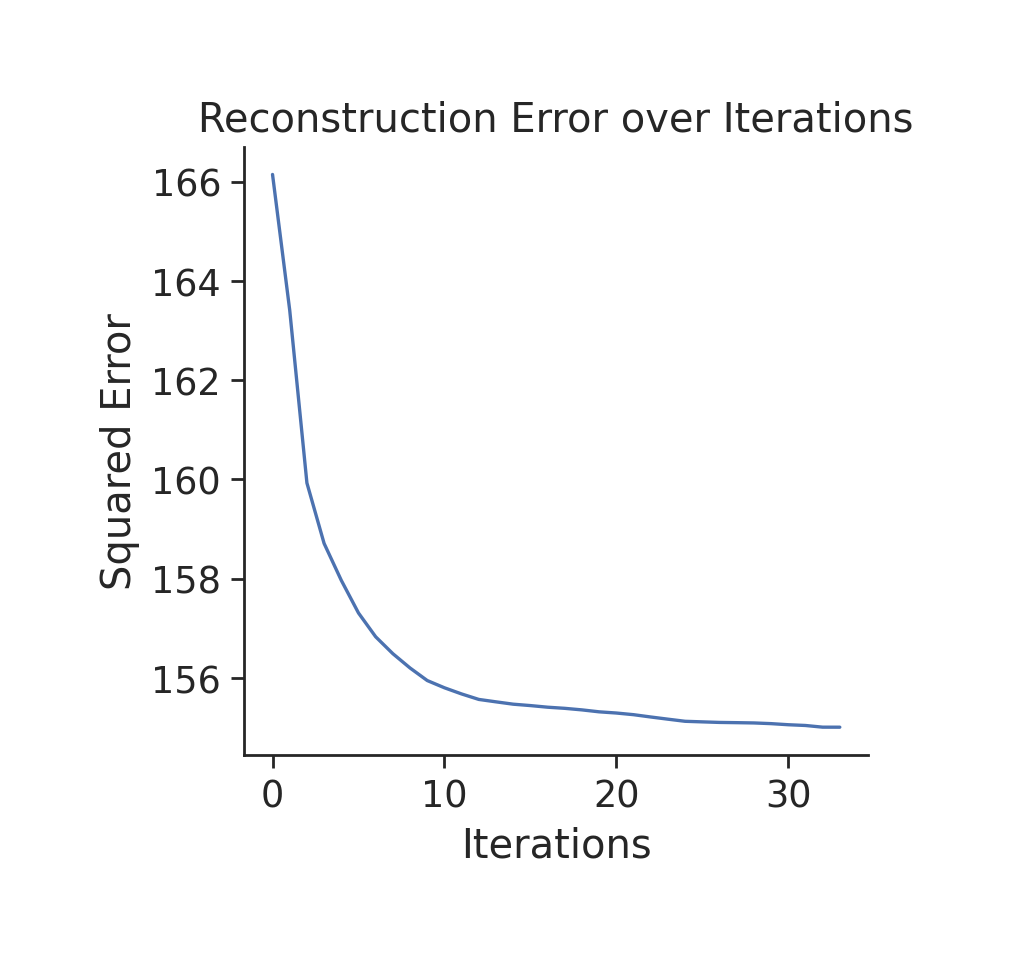

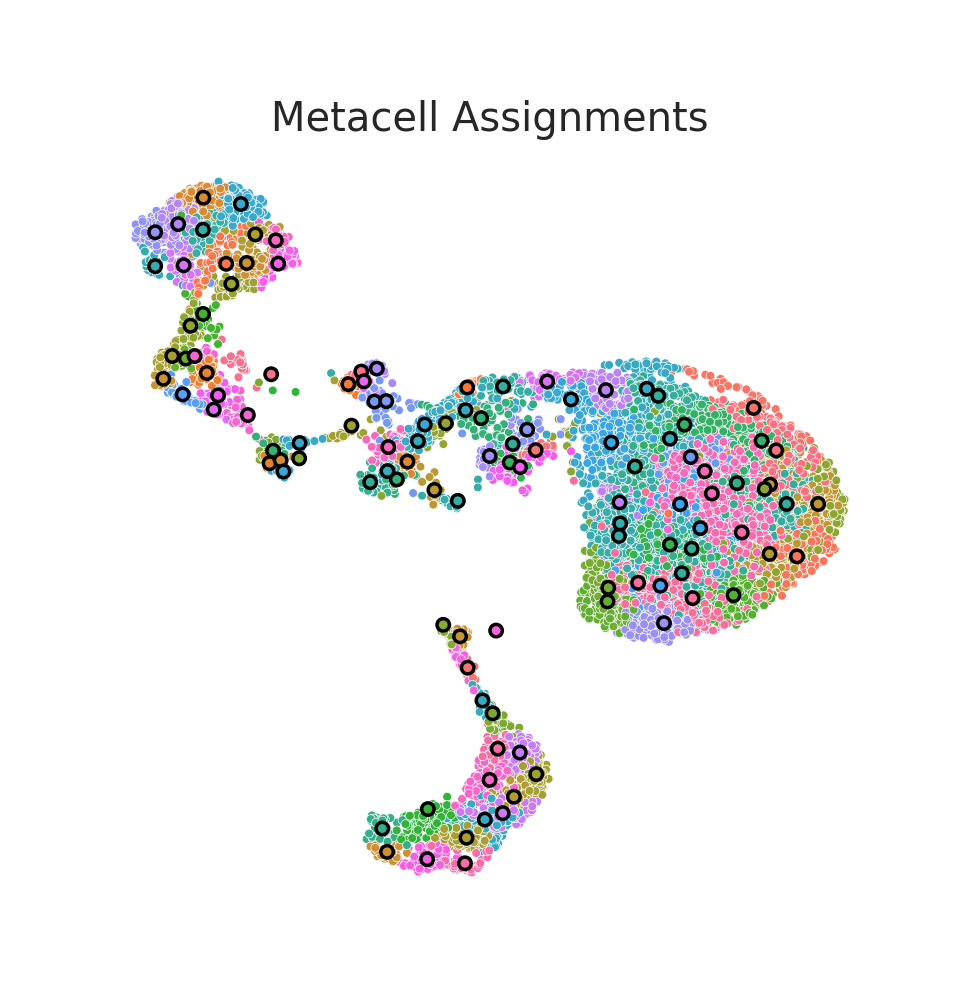

Generating Metacell matrices...
 ATAC


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [01:10<00:00,  1.64it/s]


 RNA


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 115/115 [00:00<00:00, 238.85it/s]


INFO     Assigning celltype to metacells...

INFO     Assigning cell_state_masks to metacells...

In [11]:
meta_mdata = scm.tl.build_metacells_SEACells(
                mdata,
                rna_key="RNA",
                atac_key="ATAC",
                rna_dr_key="X_pca",
                atac_dr_key="X_svd",
                rna_layer="counts",
                atac_layer="counts",
                groupby = "celltype",
                mask_key = "cell_state_masks",
                embed_key = "X_umap",
                t_key = "palantir_pseudotime",
                use_gpu=True
            )

## Conduct lineage-specifc scATACseq analysis

We will now demonstrate the lineage-specific analysis workflow. For this tutorial, we will select the **'NaiveB'** lineage as our target of interest.

In [13]:
cell_state = "NaiveB"

### Peak-gene correlation test

A key step in building a GRN is to link distal regulatory elements (peaks, or cCREs) to their potential target genes. Here, we identify peak-gene pairs by correlating peak accessibility and gene expression across metacells within our selected lineage.

First, we filter both the single-cell (`mdata`) and metacell (`meta_mdata`) objects to include only the 'NaiveB' cells.

In [14]:
mdata_fil = mdata[mdata["RNA"].obsm["cell_state_masks"][cell_state]].copy()
meta_mdata_fil = meta_mdata[meta_mdata.obsm["cell_state_masks"][cell_state]].copy()

Next, we run `scm.tl.connect_peaks_genes`. This function computes a Pearson correlation between gene expression and peak accessibility using the aggregated `meta_mdata_fil` object.

The current implementation is inspired by the `SEACells` `tfactivity.py` module (see [source code](https://www.google.com/search?q=https://github.com/dpeerlab/SEACells/blob/main/SEACells/tfactivity.py)).

:::{note}
We are actively working on integrating additional peak-to-gene linkage methods. `scMagnify` also supports importing pre-computed peak-gene associations derived from other algorithms.
:::

In [17]:
mdata_fil = scm.tl.connect_peaks_genes(
                mdata_fil,                                     
                meta_mdata_fil, 
                cor_cutoff=0.1,
                pval_cutoff=0.1,
                n_jobs=20
            )

INFO     Loading transcripts from GTF file...

INFO     Calculating peak-gene correlations...

Output()

/picb/lihonglab/chenxufeng/miniconda3/envs/scm_test/lib/python3.10/site-packages/joblib/externals/loky/process_exec
utor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too 
short worker timeout or by a memory leak.
  warnings.warn(

/picb/lihonglab/chenxufeng/miniconda3/envs/scm_test/lib/python3.10/site-packages/joblib/externals/loky/process_exec
utor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too 
short worker timeout or by a memory leak.
  warnings.warn(

/picb/lihonglab/chenxufeng/miniconda3/envs/scm_test/lib/python3.10/site-packages/joblib/externals/loky/process_exec
utor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too 
short worker timeout or by a memory leak.
  warnings.warn(

/picb/lihonglab/chenxufeng/miniconda3/envs/scm_test/lib/python3.10/site-packages/joblib/externals/loky/process_exec
utor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too 
short worker timeout or by a memory leak.
  warnings.warn(

/picb/lihonglab/chenxufeng/miniconda3/envs/scm_test/lib/python3.10/site-packages/joblib/externals/loky/process_exec
utor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too 
short worker timeout or by a memory leak.
  warnings.warn(

/picb/lihonglab/chenxufeng/miniconda3/envs/scm_test/lib/python3.10/site-packages/joblib/externals/loky/process_exec
utor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too 
short worker timeout or by a memory leak.
  warnings.warn(

/picb/lihonglab/chenxufeng/miniconda3/envs/scm_test/lib/python3.10/site-packages/joblib/externals/loky/process_exec
utor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too 
short worker timeout or by a memory leak.
  warnings.warn(

/picb/lihonglab/chenxufeng/miniconda3/envs/scm_test/lib/python3.10/site-packages/joblib/externals/loky/process_exec
utor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too 
short worker timeout or by a memory leak.
  warnings.warn(

/picb/lihonglab/chenxufeng/miniconda3/envs/scm_test/lib/python3.10/site-packages/joblib/externals/loky/process_exec
utor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too 
short worker timeout or by a memory leak.
  warnings.warn(

/picb/lihonglab/chenxufeng/miniconda3/envs/scm_test/lib/python3.10/site-packages/joblib/externals/loky/process_exec
utor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too 
short worker timeout or by a memory leak.
  warnings.warn(

/picb/lihonglab/chenxufeng/miniconda3/envs/scm_test/lib/python3.10/site-packages/joblib/externals/loky/process_exec
utor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too 
short worker timeout or by a memory leak.
  warnings.warn(

                  Peak-Gene Correlations Summary                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                      Metric ┃ Value                            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│             Number of genes │ 3281                             │
│             Number of peaks │ 216477                           │
│                     Cutoffs │ Correlation > 0.1, P-value < 0.1 │
│ Number of significant peaks │ 24441                            │
│ Number of significant genes │ 3173                             │
└─────────────────────────────┴──────────────────────────────────┘

### Motif Scanning

After identifying the peak-gene links, the next step is to determine which TFs bind to these peaks (cCREs). We use {py:class}`~scmagnify.tools.MotifScanner` to scan the DNA sequence of each peak for known TF binding motifs.

This tool is built upon the `MOODS` library {cite}`Korhonen_` for efficient Position Weight Matrix (PWM) matching. For detailed explanations of scanning parameters and the underlying principles, please refer to the [MOODS documentation](https://www.cs.helsinki.fi/u/pib/MOODS/).

First, we import and initialize the scanner. While the default database is the **HOCOMOCOv11_CORE collection**

In [18]:
from scmagnify.tools import MotifScanner

:::seealso scMagnify supports several built-in motif databases (like JASPAR, CIS-BP) and allows you to add your own. For a complete list and instructions, please see the [Advanced Usage/MotifScanner](./Advanced Usage/MotifScanner.md) guide. :::

You can list all available built-in databases at any time.

Finally, we call the `scanner.match()` method on our filtered mdata object. This scans all peaks defined in `mdata_fil.var` and stores the resulting motif scanning results in mdata_fil.uns['motif_scan'].

In [19]:
scanner = MotifScanner(motif_db = "HOCOMOCOv11_HUMAN")

INFO     Importing motifs from                                                                                     
         '/home/chenxufeng/WorkSpace/Git-repos/scMagnify/src/scmagnify/data/motifs/HOCOMOCOv11_HUMAN.pfm' in PFM   
         format...

INFO     Successfully imported 401 new motifs.                                                                     
         Total motifs in scanner: 401.

In [20]:
scanner.show_motif_databases()

               Available Motif Databases                
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Motif Database    ┃ Number of Motifs ┃ Number of TFs ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ CIS-BP            │            10033 │     5600      │
│ CIS-BP_FigR_HUMAN │             1141 │     1141      │
│ CIS-BP_FigR_MOUSE │              890 │      890      │
│ HOCOMOCOv11_HUMAN │              401 │      401      │
│ HOCOMOCOv11_MOUSE │              356 │      356      │
│ HOCOMOCOv13_HUMAN │             1611 │     1109      │
│ HOCOMOCOv13_MOUSE │             1253 │      811      │
│ HOMER             │              436 │      428      │
└───────────────────┴──────────────────┴───────────────┘

In [21]:
mdata_fil = scanner.match(mdata_fil)

Output()

        Motif Scan Summary         
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃                  Metric ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│   Number of motifs used │ 401   │
│ Number of peaks scanned │ 24441 │
│      Final score cutoff │ > 0   │
└─────────────────────────┴───────┘

## Save the data

In [ ]:
mdata_fil.write(os.path.join(settings.data_dir, "mdata_tcelldep-bm_02_NaiveB.h5mu"))
meta_mdata_fil.write(os.path.join(settings.data_dir, "meta_mdata_tcelldep-bm_02_NaiveB.h5ad"))

## Closing matters

### What's next?

In this tutorial, you learned how to build metacells with `SEACells`, perform peak-gene correlation, and use `MotifScanner` to construct a high-confidence TF binding network.

You now have both required inputs:
1.  Dynamic gene expression (from Tutorial 1)
2.  A TF binding network (from this tutorial)

For the next steps, we recommend the following:

-   Proceed to the next tutorial to **[Infer the Multi-scale Gene Regulatory Network](./Tutorial_3_Regulation_Inference.md)**. This step combines both inputs using the `scm.MAGNI` model to infer the GRN and calculate TF activities.
-   Refer to the {doc}`API <scmagnify>` to explore the available parameter values that can be used to customize these computations for your data.

If you encounter any bugs or have suggestions for new features, please open an [issue](https://github.com/your_repo_link/issues). For general questions, please post on the [scverse discourse](https://discourse.scverse.org/) or contact us at chenxufeng2022@sinh.ac.cn.


### Package versions

In [ ]:
import session_info 
session_info.show()